In [34]:
import pandas as pd
import seaborn as sns

### 1. 따릉이 대여소 정보 데이터 전처리

In [23]:
# 1. 따릉이 대여소 정보 데이터 읽어오기
df1 = pd.read_csv('data/1/공공자전거 대여소 정보(22.12월 기준).csv', encoding='cp949')

#### 데이터셋 구조 조정 및 불필요한 컬럼 제거

In [ ]:
# 불필요한 컬럼 제거
df1 = df1.iloc[:, 0:6]
df1.rename(columns={'대여소\n번호':'대여소번호',
                    '보관소(대여소)명':'대여소명',
                    '소재지(위치)':'자치구',
                    'Unnamed: 3':'상세주소',
                    'Unnamed: 4':'위도',
                    'Unnamed: 5':'경도'}, inplace=True)

# 불필요한 로우 제거
df1 = df1[4:]

In [ ]:
# 태블로에서 사용하기 위해 변경한 데이터셋을 엑셀파일로 저장
df1.to_excel('공공자전거 대여소 정보(22.12월 기준)_수정.xlsx', index=False)

### 2. 따릉이 대여소별 시간 단위 대여가능 수량 데이터 전처리

In [8]:
# 2. 시간 단위 대여가능 수량 데이터 읽어오기
df2_lst = []
# 2023년 월별 마지막 일
months = {1:31, 2:28, 3:31, 4:30, 5:31, 6:30, 7:31, 8:31, 9:30, 10:31, 11:30, 12:31}
# 데이터가 월별 초반, 후반으로 나뉘어져 있음
for m in range(1, 13, 1):
    for d in [1, 16]:
        if d == 1:
            addr = f'data/2/data_23{m:02}{d:02}~23{m:02}15.csv'
        else:
            addr = f'data/2/data_23{m:02}{d:02}~23{m:02}{months[m]}.csv'
        # 컬럼명이 없어서 names로 컬럼명을 설정해줌
        # 같은 일시, 대여소번호, 시간대 별로 6개씩 행이 있는 걸로 보아 하나의 시간대에서 10분 단위로 거치대 수량 값이 있는 것으로 보임
        # 정시에 해당하는 값 (6개 값 중 첫번째 값)만 사용하기 위해 중복 제거
        df2_lst.append(pd.read_csv(addr, names=['일시', '대여소번호', '대여소명', '시간대', '거치대수량'], encoding='cp949').drop_duplicates(subset=['일시', '대여소번호', '대여소명', '시간대']))

#### 필요한 대여소 선택 및 월별로 나눠진 데이터셋을 하나의 데이터셋으로 병합

In [9]:
# 진관동 일대 대여소에서 발생한 대여이력만 선택
targets = [969, 968, 942, 904, 903, 937, 976, 954, 938, 902, 962, 960, 905]

# 진관동 대여소만 선택하기 위한 함수
def modify_df2(df2):
    df2 = df2[df2['대여소번호'].isin(targets)]
    return df2

In [10]:
# 수정된 데이터셋을 저장
modified_df2_lst = []

# 각 월별 데이터셋에서 진관동 대여소만 선택
for df2 in df2_lst:
    modified_df2_lst.append(modify_df2(df2))

In [99]:
# 수정된 월별 데이터셋을 하나로 병합
df2 = pd.concat(modified_df2_lst)

In [100]:
# 변경한 데이터셋을 엑셀파일로 저장
df2.to_excel('따릉이 시간단위 대여가능 수량_23_수정.xlsx', index=False)

### 3. 따릉이 대여이력 정보 데이터 전처리

In [ ]:
# 3. 따릉이 대여이력 정보 데이터 읽어오기
df3_lst = []
for i in range(12):
    # {i:02} == i변수값을 두자리수가 되도록 앞에 0을 채워줌
    addr = f'data/3/서울특별시 공공자전거 대여이력 정보_23{(i + 1):02}.csv'
    df3_lst.append(pd.read_csv(addr, encoding='cp949'))

#### 불필요한 컬럼 제거 및 필요한 대여소만 선택

In [23]:
# 진관동 일대 대여소에서 발생한 대여이력만 선택
targets = [969, 968, 942, 904, 903, 937, 976, 954, 938, 902, 962, 960, 905]
# 반납대여소가 5자리로 표기되어 있어 5자리 숫자 형태의 대여소번호 리스트 생성
targets5 = []
for t in targets:
    targets5.append(f'{t:05}')

# 월별로 데이터셋 수정을 하기 위한 함수. 수정된 데이터셋을 리턴
def modify_df3(df3, i):
    # 필요한 컬럼만 선택
    df3 = df3[['대여일시', '대여 대여소번호', '대여 대여소명', '반납일시', '반납대여소번호', '반납대여소명', '생년', '성별', '이용자종류']]
    # 타겟으로 삼은 대여소에 해당하는 대여이력만 선택 
    df3 = df3[(df3['대여 대여소번호'].isin(targets)) & (df3['반납대여소번호'].isin(targets5))]
    return df3

In [24]:
# 월별 데이터셋에 수정 함수를 적용 후 리스트에 저장
modified_df3_lst = []
for i in range(len(df3_lst)):
    modified_df3_lst.append(modify_df3(df3_lst[i], i))

In [25]:
# 수정된 월별 데이터셋을 하나로 병합
df3 = pd.concat(modified_df3_lst)

In [26]:
# 태블로에서 사용하기 위해 변경한 데이터셋을 엑셀파일로 저장
df3.to_excel('서울특별시 공공자전거 대여이력 정보_23_수정.xlsx', index=False)

### 4. 서울시 날씨 정보 데이터 전처리

In [22]:
df4 = pd.read_csv('data/4/OBS_ASOS_DD_20240922121807.csv', encoding='cp949')

#### 불필요한 컬럼 제거 및 결측치 처리

In [23]:
# 불필요한 지점, 지점명 컬럼 제거
df4 = df4.iloc[:, 2:]
# 일강수량, 일 최심적설 컬럼의 결측치 0으로 처리
df4.fillna(0, inplace=True)

In [29]:
df4

,일시,평균기온(°C),최저기온(°C),최고기온(°C),일강수량(mm),일 최심적설(cm)
0,2023-01-01,-0.2,-4.3,3.8,0.0,0.0
1,2023-01-02,-4.5,-7.4,-0.4,0.0,0.0
2,2023-01-03,-5.0,-9.0,0.6,0.0,0.0
3,2023-01-04,-1.8,-5.7,3.3,0.0,0.0
4,2023-01-05,-1.6,-5.6,3.6,0.0,0.0
...,...,...,...,...,...,...
360,2023-12-27,1.5,-2.8,6.8,0.0,0.0
361,2023-12-28,1.2,-1.7,4.4,0.0,0.0
362,2023-12-29,1.3,-1.5,4.6,0.0,0.0
363,2023-12-30,0.6,-0.9,2.1,13.1,12.2


### 5. 서울시 대기오염도 데이터 전처리

In [24]:
df5 = pd.read_csv('data/5/일별평균대기오염도_2023.csv', encoding='cp949')

In [25]:
# 은평구에 해당하는 데이터만 선택
df5 = df5[df5['측정소명'] == '은평구']

# 측정일시를 'yyyy-mm-dd'형식으로 변형
df5['측정일시'] = df5['측정일시'].apply(lambda x: str(x)[0:4] + '-' + str(x)[4:6] + '-' + str(x)[6:8])

# 불필요한 컬럼 제거
# 사람들의 주요 관심사인 미세먼지농도와 초미세먼지농도 컬럼만 선택
# 결측치 대체를 위해 인덱스 재설정
df5.reset_index(inplace=True)
df5 = df5.iloc[:, [1, 7, 8]]

# 결측치가 존재함. 6/17, 8/8, 9/13 전날과 다음날의 값의 평균으로 결측치 대체
# 미세먼지농도 컬럼 결측치 대체
for i in df5[df5['미세먼지농도(㎍/㎥)'].isna()].index.to_list():
    df5.iloc[i, 1] = round((df5.iloc[(i - 1), 1] + df5.iloc[(i + 1), 1]) / 2, 0)
# 초미세먼지농도 컬럼 결측치 대체
for i in df5[df5['초미세먼지농도(㎍/㎥)'].isna()].index.to_list():
    df5.iloc[i, 2] = round((df5.iloc[(i - 1), 1] + df5.iloc[(i + 1), 1]) / 2, 0)

In [180]:
df5

,측정일시,미세먼지농도(㎍/㎥),초미세먼지농도(㎍/㎥)
0,2023-01-01,55.0,37.0
1,2023-01-02,23.0,7.0
2,2023-01-03,26.0,11.0
3,2023-01-04,31.0,17.0
4,2023-01-05,41.0,26.0
...,...,...,...
360,2023-12-27,74.0,54.0
361,2023-12-28,49.0,38.0
362,2023-12-29,39.0,30.0
363,2023-12-30,29.0,22.0


### 6. 은평뉴타운 1지구 일별 대여량 데이터셋(df_day) 만들기

In [2]:
# 수정한 일별 대여이력 데이터셋 읽어오기
df3 = pd.read_excel('data/3/서울특별시 공공자전거 대여이력 정보_23_수정.xlsx')

In [181]:
df3

,대여일시,대여 대여소번호,대여 대여소명,반납일시,반납대여소번호,반납대여소명,생년,성별,이용자종류
0,2023-01-01 00:04:01,960,구파발역 환승센터,2023-01-01 00:06:24,954,은평뉴타운구파발9단지,1969,M,내국인
1,2023-01-01 00:08:58,905,구파발역 2번출구,2023-01-01 00:33:19,902,진관동 은빛초등학교,1944,F,내국인
2,2023-01-01 01:57:37,905,구파발역 2번출구,2023-01-01 02:02:25,954,은평뉴타운구파발9단지,1986,\N,내국인
3,2023-01-01 01:59:17,905,구파발역 2번출구,2023-01-01 02:06:46,903,은평뉴타운 아이파크,1968,M,내국인
4,2023-01-01 01:57:58,905,구파발역 2번출구,2023-01-01 02:07:52,904,은평뉴타운 푸르지오,1982,\N,내국인
...,...,...,...,...,...,...,...,...,...
84999,2023-12-31 23:29:39,902,진관동 은빛초등학교,2023-12-31 23:35:10,905,구파발역 2번출구,\N,F,내국인
85000,2023-12-31 23:42:29,902,진관동 은빛초등학교,2023-12-31 23:42:39,902,진관동 은빛초등학교,2007,M,내국인
85001,2023-12-31 23:39:35,905,구파발역 2번출구,2023-12-31 23:44:22,902,진관동 은빛초등학교,\N,F,내국인
85002,2023-12-31 23:43:11,902,진관동 은빛초등학교,2023-12-31 23:49:19,942,상림마을 생태공원,2007,M,내국인


In [182]:
# 대여일 기준으로 대여량의 합을 구하기 위해 연도-월-일 형태의 컬럼을 생성
df3['대여일'] = df3['대여일시'].apply(lambda x: x[:10])

# fill_value=0 == 계산 후 나오는 null값을 0으로 채워줌
df_day = pd.pivot_table(df3, index='대여일', columns='대여 대여소번호', values='대여 대여소명', aggfunc='count', fill_value=0)

# 일별 전체 대여소에서 발생한 대여량을 더한 total 컬럼 생성
df_day['total'] = df_day.sum(axis=1)

# 대여일을 컬럼으로
df_day.reset_index(inplace=True)

# 날씨 데이터 조인
df_day = pd.merge(df_day, df4, how='inner', left_on='대여일', right_on='일시')
# 대기오염도 데이터 조인
df_day = pd.merge(df_day, df5, how='inner', left_on='대여일', right_on='측정일시')
# 조인하면서 생긴 중복 컬럼 제거
df_day.drop(['일시', '측정일시'], axis=1, inplace=True)

# 공휴일 표시를 위한 컬럼 생성
df_day['red'] = 0
# 2023년도 공휴일들
holidays = ['2023-01-01', '2023-01-21', '2023-01-22', '2023-01-23', '2023-01-24', '2023-03-01', '2023-05-05', '2023-05-27', '2023-05-29', '2023-06-06',
            '2023-08-15', '2023-09-28', '2023-09-29', '2023-09-30', '2023-10-02', '2023-10-03', '2023-10-09', '2023-12-25']
# 공휴일 컬럼 값을 1로 변경
for i in range(len(df_day)):
    # 토요일과 일요일 계산
    if (i % 7 == 0) or (i % 7 == 6):
        df_day.loc[i, 'red'] = 1
    # 공휴일에 해당하는지 확인
    elif df_day.loc[i, '대여일'] in holidays:
        df_day.loc[i, 'red'] = 1

In [183]:
df_day.to_excel('은평뉴타운 1지구 일별 대여량.xlsx', index=False)

### 7. 시간대별로 대여소별 대여수량 및 반납수량 데이터셋(df_time) 만들기

In [22]:
df3 = pd.read_excel('data/3/서울특별시 공공자전거 대여이력 정보_23_수정.xlsx')

In [23]:
# 시간대별로 조회하기 위해 새로운 컬럼 생성
df3['대여 시간'] = df3['대여일시'].apply(lambda x: x[11:13])
df3['반납 시간'] = df3['반납일시'].apply(lambda x: x[11:13])

# 대여 시간대별로 각 대여소에서 발생한 대여량을 구함
df_time_1 = df3.pivot_table(index=['대여 시간', '대여 대여소번호'], values='대여 대여소명', aggfunc='count').reset_index()
# 반납 시간대별로 각 대여소에 반납된 수를 구함
df_time_2 = df3.pivot_table(index=['반납 시간', '반납대여소번호'], values='반납대여소명', aggfunc='count').reset_index()

# 시간대별 대여소에서 발생한 대여 수량과 반납 수량 데이터프레임을 병합
df_time = pd.merge(df_time_1, df_time_2, how='inner', left_on=['대여 시간', '대여 대여소번호'], right_on=['반납 시간', '반납대여소번호'])
# 중복 컬럼 제거 및 컬럼명 변경
df_time = df_time[['대여 시간', '대여 대여소번호', '대여 대여소명', '반납대여소명']]
df_time.rename(columns={'대여 시간': '시간대',
                        '대여 대여소번호': '대여소번호',
                        '대여 대여소명': '대여 수량',
                        '반납대여소명': '반납 수량'}, inplace=True)

In [45]:
df_time.to_excel('시간대별 대여수량 및 반납수량.xlsx', index=False)

In [112]:
df_time

,시간대,대여소번호,대여 수량,반납 수량
0,00,902,44,286
1,00,903,82,321
2,00,904,61,279
3,00,905,537,163
4,00,937,23,30
...,...,...,...,...
304,23,960,451,43
305,23,962,558,282
306,23,968,37,57
307,23,969,15,93


### 8. 대여소별 출근시간 거치대 수량 데이터셋(df2_5789) 만들기

In [2]:
df2 = pd.read_excel('data/2/따릉이 시간단위 대여가능 수량_23_수정.xlsx')

In [3]:
# 오전 7시 거치대 수량 컬럼, 오전 8시 거치대 수량 컬럼을 만들기 위해 데이터셋 가공
df2_5 = df2[df2['시간대'] == 5]
df2_7 = df2[df2['시간대'] == 7]
df2_8 = df2[df2['시간대'] == 8]
df2_9 = df2[df2['시간대'] == 9]
df2_57 = pd.merge(left=df2_5, right=df2_7, how='inner', on=['일시', '대여소번호', '대여소명'])
df2_89 = pd.merge(left=df2_8, right=df2_9, how='inner', on=['일시', '대여소번호', '대여소명'])
df2_5789 = pd.merge(left=df2_57, right=df2_89, how='inner', on=['일시', '대여소번호', '대여소명'])
df2_5789
# 불필요한 컬럼 제거 및 컬럼명 변경
df2_5789 = df2_5789[['일시', '대여소번호', '대여소명', '거치대수량_x_x', '거치대수량_y_x', '거치대수량_x_y', '거치대수량_y_y']]
df2_5789.rename(columns={'거치대수량_x_x': '거치대수량_5',
                       '거치대수량_y_x': '거치대수량_7',
                       '거치대수량_x_y': '거치대수량_8',
                       '거치대수량_y_y': '거치대수량_9'}, inplace=True)

# 거치 수량이 0인 날을 나타내는 컬럼 생성
df2_5789['zero_day'] = df2_5789['거치대수량_7'] * df2_5789['거치대수량_8']
df2_5789['zero_day'] = df2_5789['zero_day'].apply(lambda x: 0 if x > 0 else 1)
df2_5789

,일시,대여소번호,대여소명,거치대수량_5,거치대수량_7,거치대수량_8,거치대수량_9,zero_day
0,2023-01-01,902,902. 진관동 은빛초등학교,8,8,7,7,0
1,2023-01-01,903,903. 은평뉴타운 아이파크,3,3,3,3,0
2,2023-01-01,904,904. 은평뉴타운 푸르지오,10,9,9,9,0
3,2023-01-01,905,905. 구파발역 2번출구,41,44,45,45,0
4,2023-01-01,937,937. 상림마을 롯데캐슬2단지 옆,10,10,10,10,0
...,...,...,...,...,...,...,...,...
4584,2023-12-31,960,960. 구파발역 환승센터,10,11,11,13,0
4585,2023-12-31,962,962. 은평뉴타운 힐데스하임,12,12,12,12,0
4586,2023-12-31,968,968. 은평뉴타운 상림마을 13단지,2,1,1,1,0
4587,2023-12-31,969,969. 은평 지웰테라스,2,2,2,2,0


In [ ]:
df2_5789.to_excel('대여소별 출근시간 거치대 수량.xlsx')

### 9. 942번 대여소의 일별 데이터셋(df_942_day) 만들기

In [26]:
df2 = pd.read_excel('data/2/따릉이 시간단위 대여가능 수량_23_수정.xlsx')
# 4번에서 df4 읽기
# 5번에서 df5 읽기
df6 = pd.read_excel('은평뉴타운 1지구 일별 대여량.xlsx')

데이터를 가공하여 날짜별 15시 거치수량과 다음날 아침시간(7, 8, 9시)의 거치수량을 알 수 있도록 함

In [27]:
# 942번 대여소의 오전 7-9시, 오후 3시에 해당하는 데이터만 선택 
df2_942 = df2[(df2['대여소번호'] == 942) & (df2['시간대'].isin([7, 8, 9, 15]))]
# unnamed:0, 대여소번호, 대여소명 컬럼 제외
df2_942 = df2_942[['일시', '시간대', '거치대수량']]
# 시간대별 거치대수량 값을 컬럼으로 만들어줌
df2_942 = df2_942.pivot_table(index='일시', columns='시간대', values='거치대수량').reset_index()

# 날씨 데이터에서 일시, 평균기온, 일강수량, 일최심적설 컬럼 선택하여 df2_942 데이터프레임에 추가
df4 = df4.iloc[:,[0, 1, 4, 5]]
df24_942 = pd.merge(df2_942, df4, how='inner', on='일시')

# 대기오염도 데이터를 df24_942 데이터프레임에 추가
df245_942 = pd.merge(df24_942, df5, how='inner', left_on='일시', right_on='측정일시')

# 1지구 일별 대여량 데이터에서 공휴일(red) 컬럼을 선택하여 df245_942 데이터프레임에 추가
df6 = df6[['대여일', 'red']]
df2456_942 = pd.merge(df245_942, df6, how='inner', left_on='일시', right_on='대여일')

# 합친 데이터프레임(df2456_942)에서 불필요한 컬럼(7, 9, 측정일시, 대여일) 제거
df_942_day = df2456_942.iloc[:, [0, 2, 4, 5, 6, 7, 9, 10, 12]]

In [28]:
# 다음날 오전 8시의 거치대수량, 평균기온, 일강수량, 일최심적설, 미세먼지농도, 초미세먼지농도, red 값을 컬럼으로 만들어줌
# ex) 1월 1일의 8 컬럼에는 1월 2일 오전 8시의 거치대수량 값이 들어가야함
# 1월 2일부터 오전 8시 거치대수량
df_tmp = df_942_day[[8, '평균기온(°C)', '일강수량(mm)', '일 최심적설(cm)', '미세먼지농도(㎍/㎥)', '초미세먼지농도(㎍/㎥)', 'red']][1:]
# 12월 31일은 내년 1월 1일 오전 8시의 거치대수량 값이 필요하기 때문에 제외할 예정
df_tmp.loc[354] = [-1, -1, -1, -1, -1, -1, -1]
# concat 전에 인덱스를 재설정해줌
df_tmp.reset_index(drop=True, inplace=True)
# 당일 오전 8시 거치대수량 컬럼 삭제
df_942_day = df_942_day.drop(8, axis=1)
# 다음날 오전 8시 거치대수량 컬럼을 추가
df_942_day = pd.concat([df_942_day, df_tmp], axis=1)

# 컬럼명 변경
df_942_day.columns = ['일시', '15시 거치수량', '평균기온', '일강수량', '일최심적설', '미세먼지농도', '초미세먼지농도', '공휴일', 
                      '다음날 8시 거치수량', '다음날 평균기온', '다음날 일강수량', '다음날 일최심적설', '다음날 미세먼지농도', '다음날 초미세먼지농도', '다음날 공휴일']

9/7 - 9/14 데이터 일부 없음, 10/10 - 10/15 데이터 일부 없음

In [ ]:
# 다음날 데이터가 없는 날짜들 제거 (09-07, 10-10, 12-31)
df_942_day = df_942_day[~df_942_day['일시'].isin(['2023-09-07', '2023-10-10', '2023-12-31'])]

In [33]:
df_942_day.to_excel('942번 대여소 일별 데이터셋.xlsx')

오전 8시에 942번 대여소에서 발생한 대여량 계산

In [19]:
df3 = pd.read_excel('data/3/서울특별시 공공자전거 대여이력 정보_23_수정.xlsx')
df3

,대여일시,대여 대여소번호,대여 대여소명,반납일시,반납대여소번호,반납대여소명,생년,성별,이용자종류
0,2023-01-01 00:04:01,960,구파발역 환승센터,2023-01-01 00:06:24,954,은평뉴타운구파발9단지,1969,M,내국인
1,2023-01-01 00:08:58,905,구파발역 2번출구,2023-01-01 00:33:19,902,진관동 은빛초등학교,1944,F,내국인
2,2023-01-01 01:57:37,905,구파발역 2번출구,2023-01-01 02:02:25,954,은평뉴타운구파발9단지,1986,\N,내국인
3,2023-01-01 01:59:17,905,구파발역 2번출구,2023-01-01 02:06:46,903,은평뉴타운 아이파크,1968,M,내국인
4,2023-01-01 01:57:58,905,구파발역 2번출구,2023-01-01 02:07:52,904,은평뉴타운 푸르지오,1982,\N,내국인
...,...,...,...,...,...,...,...,...,...
84999,2023-12-31 23:29:39,902,진관동 은빛초등학교,2023-12-31 23:35:10,905,구파발역 2번출구,\N,F,내국인
85000,2023-12-31 23:42:29,902,진관동 은빛초등학교,2023-12-31 23:42:39,902,진관동 은빛초등학교,2007,M,내국인
85001,2023-12-31 23:39:35,905,구파발역 2번출구,2023-12-31 23:44:22,902,진관동 은빛초등학교,\N,F,내국인
85002,2023-12-31 23:43:11,902,진관동 은빛초등학교,2023-12-31 23:49:19,942,상림마을 생태공원,2007,M,내국인


In [20]:
# 942번 대여소에세 대여하는 행만 선택
df3_942 = df3[(df3['대여 대여소번호'] == 942)]
# 인덱스 재설정
df3_942.reset_index(drop=True, inplace=True)
# 942번 대여소에서 대여가 일어난 날짜, 시간, 대여량(대여인지 반납인지)을 컬럼으로 생성
date_col = []
time_col = []
rent_col = []
for i in range(len(df3_942)):
    if df3_942.loc[i, '대여 대여소번호'] == 942:
        # 대여일시 컬럼값(2023-01-01 00:04:01)에서 날짜에 해당하는 값(2023-01-01)만 잘라냄
        date_col.append(df3_942.loc[i, '대여일시'][0:10])
        # 대여일시 컬럼값(2023-01-01 00:04:01)에서 시간에 해당하는 값(00)만 잘라냄
        time_col.append(df3_942.loc[i, '대여일시'][11:13])
        rent_col.append(1)
df3_942['날짜'] = date_col
df3_942['시간'] = time_col
df3_942['대여량'] = rent_col

C:\Users\xjrma\AppData\Local\Temp\ipykernel_7556\1669452719.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3_942['날짜'] = date_col
C:\Users\xjrma\AppData\Local\Temp\ipykernel_7556\1669452719.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3_942['시간'] = time_col
C:\Users\xjrma\AppData\Local\Temp\ipykernel_7556\1669452719.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

In [21]:
# 필요한 컬럼만 선택
df3_942_dtr = df3_942[['날짜', '시간', '대여량']]
# 날짜별로 시간대별 대여량을 컬럼을 갖는 데이터프레임으로 가공
df3_942_dtr = df3_942_dtr.pivot_table(index='날짜', columns='시간', values='대여량', aggfunc='sum').reset_index().fillna(0)

In [37]:
df = df3_942_dtr[['날짜', '07', '08', '09']]

In [38]:
df.head(30)

시간,날짜,07,08,09
0,2023-01-01,0.0,0.0,0.0
1,2023-01-02,1.0,0.0,0.0
2,2023-01-03,0.0,0.0,1.0
3,2023-01-04,1.0,0.0,1.0
4,2023-01-05,1.0,0.0,0.0
5,2023-01-06,1.0,0.0,0.0
6,2023-01-07,0.0,0.0,1.0
7,2023-01-08,0.0,0.0,0.0
8,2023-01-09,2.0,0.0,0.0
9,2023-01-10,0.0,0.0,1.0


<Axes: xlabel='날짜', ylabel='08'>

c:\Users\xjrma\anaconda3\envs\home\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 45216 (\N{HANGUL SYLLABLE NAL}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
c:\Users\xjrma\anaconda3\envs\home\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 51676 (\N{HANGUL SYLLABLE JJA}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
c:\Users\xjrma\anaconda3\envs\home\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 45216 (\N{HANGUL SYLLABLE NAL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\xjrma\anaconda3\envs\home\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51676 (\N{HANGUL SYLLABLE JJA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


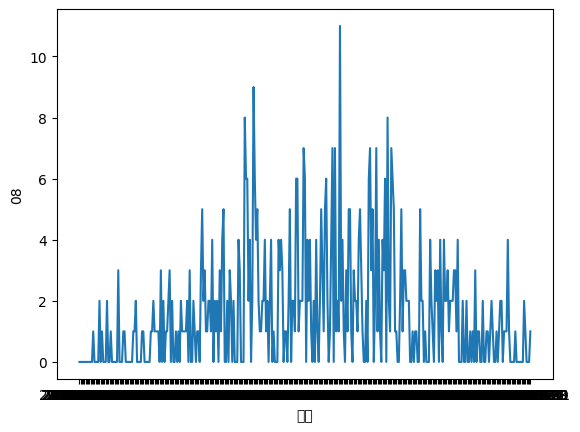

In [35]:
sns.lineplot(data=df, x='날짜', y='08')

In [33]:
df

시간,날짜,07,08,09
0,2023-01-01,0.0,0.0,0.0
1,2023-01-02,1.0,0.0,0.0
2,2023-01-03,0.0,0.0,1.0
3,2023-01-04,1.0,0.0,1.0
4,2023-01-05,1.0,0.0,0.0
...,...,...,...,...
356,2023-12-27,0.0,1.0,1.0
357,2023-12-28,0.0,0.0,1.0
358,2023-12-29,1.0,0.0,0.0
359,2023-12-30,0.0,0.0,0.0


In [30]:
df3_942

,대여일시,대여 대여소번호,대여 대여소명,반납일시,반납대여소번호,반납대여소명,생년,성별,이용자종류,날짜,시간,대여량
0,2023-01-01 16:37:42,942,상림마을 생태공원,2023-01-01 16:42:53,954,은평뉴타운구파발9단지,1995,\N,내국인,2023-01-01,16,1
1,2023-01-01 18:26:41,942,상림마을 생태공원,2023-01-01 18:32:51,954,은평뉴타운구파발9단지,1959,\N,내국인,2023-01-01,18,1
2,2023-01-02 07:02:55,942,상림마을 생태공원,2023-01-02 07:09:57,960,구파발역 환승센터,1957,M,내국인,2023-01-02,07,1
3,2023-01-02 12:34:20,942,상림마을 생태공원,2023-01-02 12:48:35,942,상림마을 생태공원,1996,M,내국인,2023-01-02,12,1
4,2023-01-02 12:58:15,942,상림마을 생태공원,2023-01-02 13:06:26,960,구파발역 환승센터,1974,F,내국인,2023-01-02,12,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,2023-12-29 14:32:10,942,상림마을 생태공원,2023-12-29 14:38:19,902,진관동 은빛초등학교,2003,M,내국인,2023-12-29,14,1
5106,2023-12-29 16:30:48,942,상림마을 생태공원,2023-12-29 16:33:41,969,은평 지웰테라스,1960,M,내국인,2023-12-29,16,1
5107,2023-12-29 17:59:12,942,상림마을 생태공원,2023-12-29 18:05:17,954,은평뉴타운구파발9단지,1974,F,내국인,2023-12-29,17,1
5108,2023-12-30 14:36:49,942,상림마을 생태공원,2023-12-30 14:39:18,903,은평뉴타운 아이파크,1976,F,내국인,2023-12-30,14,1


In [29]:
df3_942_dtr[['날짜', '08']]

시간,날짜,08
0,2023-01-01,0.0
1,2023-01-02,0.0
2,2023-01-03,0.0
3,2023-01-04,0.0
4,2023-01-05,0.0
...,...,...
356,2023-12-27,1.0
357,2023-12-28,0.0
358,2023-12-29,0.0
359,2023-12-30,0.0
